In [1]:
# conda install gdal
# https://arset.gsfc.nasa.gov/sites/default/files/airquality/webinars/18-hires/s2-final.pdf

Physical AOD values of ODLO parameter = a × (integer value − b) where a is equal to 0.001 
and b is equal to 0 (personal communication with Bill Ridgway in NASA, August 19, 2009).

In [2]:
import gdal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds
    

In [4]:
# Opens the data HDF file and returns as a dataframe
def read_dataset(SUBDATASET_NAME, FILEPATH):
    dataset = load_data(FILEPATH)
    path = ''
    for sub, description in dataset.GetSubDatasets():
        if (description.endswith(SUBDATASET_NAME)):
            path = sub
            break
    if(path == ''):
        print(SUBDATASET_NAME + ' not found')
        return
    subdataset = gdal.Open(path)
    subdataset = subdataset.ReadAsArray()
    subdataset = pd.DataFrame(subdataset)
    return subdataset

In [5]:
# Loads the HDF file, gets the Latitude subdataset and returns the information of the nearest pixel to specified position
def find_latitude_position(CITY_LATITUDE, FILEPATH):
    dataset_to_load = 'Latitude (32-bit floating-point)'
    latitude_dataframe = read_dataset(dataset_to_load, FILEPATH)
    min_diff = 100
    row_number = -1
    column_number = -1
    rows = latitude_dataframe.shape[0]
    columns = latitude_dataframe.shape[1]
    for i in range(rows):
        for j in range(columns):
            lat = latitude_dataframe.iloc[i][j]
            diff = np.abs(lat - CITY_LATITUDE)
            if(diff < min_diff):
                min_diff = diff
                row_number = i
                column_number = j
                found_lat = lat
    if(row_number == -1 or column_number == -1):
        print("Latitude not found. You might have chosen wrong scene")
    return latitude_dataframe, row_number, column_number
    

In [6]:
# Loads the HDF file, gets the Longitude subdataset and returns the information of the nearest pixel to specified position
def find_longitude_position(CITY_LONGITUDE, LATITUDE_ROW_NUMBER, FILEPATH):
    dataset_to_load = 'Longitude (32-bit floating-point)'
    longitude_dataframe = read_dataset(dataset_to_load, FILEPATH)
    min_diff = 100
    row_number = -1
    column_number = -1
    rows = longitude_dataframe.shape[0]
    columns = longitude_dataframe.shape[1]
    for j in range(columns):
        lon = longitude_dataframe.iloc[LATITUDE_ROW_NUMBER][j]
        diff = np.abs(lon - CITY_LONGITUDE)
        if(diff < min_diff):
            min_diff = diff
            row_number = LATITUDE_ROW_NUMBER
            column_number = j
            found_lon = lon
    if(column_number == -1):
        print("Longitude not found. You might have chosen wrong scene")
    return longitude_dataframe, column_number
    

In [7]:
def find_product_value(LATITUDE_ROW_NUMBER, LONGITUDE_COLUMN_NUMBER, SUBDATASET, FILEPATH):
    dataset = read_dataset(SUBDATASET, FILEPATH)
    if(LATITUDE_ROW_NUMBER < 0 or LONGITUDE_COLUMN_NUMBER < 0):
        return -1
    return dataset.iloc[LATITUDE_ROW_NUMBER][LONGITUDE_COLUMN_NUMBER]

In [8]:
# Creates a list of values of the product under observation across all datasets
def create_list(PRODUCT, CITY_LATITUDE, CITY_LONGITUDE, FILEPATH):
    latitude_dataframe, lat_row, lat_column = find_latitude_position(CITY_LATITUDE, FILEPATH)
    if lat_row == -1:
        return -1
    longitude_dataframe, lon_column = find_longitude_position(CITY_LONGITUDE, lat_row, FILEPATH)
    city_row_number = lat_row
    city_column_number = lon_column
    if(PRODUCT == 'AOD'):
        subdataset = 'Deep_Blue_Aerosol_Optical_Depth_550_Land mod04 (16-bit integer)'
    elif(PRODUCT == 'Scattering Angle'):
        subdataset = 'Scattering_Angle mod04 (16-bit integer)'
    elif(PRODUCT == 'Cloud Fraction'):
        subdataset = 'Deep_Blue_Cloud_Fraction_Land (16-bit integer)'
    elif(PRODUCT == 'Combined'):
        subdataset = 'AOD_550_Dark_Target_Deep_Blue_Combined (16-bit integer)'
    elif(PRODUCT == 'Angstrom Exponent'):
        subdataset = 'Deep_Blue_Angstrom_Exponent_Land (16-bit integer)'
    row_begin = city_row_number - 1
    row_end = city_row_number + 1
    column_begin = city_column_number - 1
    column_end = city_column_number + 1
    total = 0
    for i in range(row_begin, row_end, 1):
        for j in range(column_begin, column_end, 1):
            pixel_value = find_product_value(i, j, subdataset, FILEPATH)
            if(pixel_value == -9999):
                pixel_value = 0
            total = total + pixel_value
    product_value = total / 9
    return product_value, latitude_dataframe.iloc[lat_row][lat_column], longitude_dataframe.iloc[lat_row][lon_column]


In [9]:
import glob
# Defining lists that we want
scattering_angle = []
deep_blue_AOD_Land = []
cloud_fraction = []
file_names = []
latitude = []
longitude = []
combined_AOD = []
angstrom_exponent = []
directory = '/Users/nimishmishra/Downloads/Kanpur MODIS Data/November' # Put here the month directory from which to extract files
for file in glob.glob(directory + '/*.hdf'):
    FILEPATH = file
    print(FILEPATH)
    scattering_angle_value, lat, lon = create_list('Scattering Angle', 26.8467, 80.9462, FILEPATH)
    deep_blue_AOD_Land_value, lat, lon = create_list('AOD', 26.8467, 80.9462, FILEPATH)
    cloud_fraction_value, lat, lon = create_list('Cloud Fraction', 26.8467, 80.9462, FILEPATH)
    combined_AOD_value, lat, lon = create_list('Combined', 26.8467, 80.9462, FILEPATH)
    angstrom_exponent_value, lat, lon = create_list('Angstrom Exponent', 26.8467, 80.9462, FILEPATH)
    print("Data collected for: " + str(lat) + " N (26.8467 N for Kanpur) and " + str(lon) + " E.(80.9462 for Kanpur)")
    file_names.append(file)
    scattering_angle.append(scattering_angle_value)
    deep_blue_AOD_Land.append(deep_blue_AOD_Land_value)
    latitude.append(lat)
    longitude.append(lon)
    cloud_fraction.append(cloud_fraction_value)
    combined_AOD.append(combined_AOD_value)
    angstrom_exponent.append(angstrom_exponent_value)

final_list = pd.DataFrame()
final_list['File Name'] = pd.Series(file_names)
final_list['Scattering_angle'] = pd.Series(scattering_angle)
final_list['Deep Blue AOD'] = pd.Series(deep_blue_AOD_Land)
final_list['Cloud Fraction'] = pd.Series(cloud_fraction)
final_list['Combined AOD'] = pd.Series(combined_AOD)
final_list['Angstrom Exponent'] = pd.Series(angstrom_exponent)
final_list['Latitude'] = pd.Series(latitude)
final_list['Longitude'] = pd.Series(longitude)
path = '/Users/nimishmishra/Desktop/2018_Sep.csv'
final_list.to_csv(path)

/Users/nimishmishra/Downloads/Kanpur MODIS Data/November/2018.11.18.hdf
Data collected for: 26.846771 N (26.8467 N for Kanpur) and 81.00919 E.(80.9462 for Kanpur)
/Users/nimishmishra/Downloads/Kanpur MODIS Data/November/2018.11.24.hdf
Data collected for: 26.84687 N (26.8467 N for Kanpur) and 80.901535 E.(80.9462 for Kanpur)
/Users/nimishmishra/Downloads/Kanpur MODIS Data/November/2018.11.30.hdf


KeyboardInterrupt: 

In [116]:
#Plotting out graphs

In [10]:
def plot(x_axis, y_axis_1, y_axis_2, label1, label2, directory, month):
    figure = plt.figure()
    ax = sns.lineplot(x=date, y=y_axis_1)
    ax = sns.lineplot(x=x_axis, y=y_axis_2)
    figure.legend(labels = [label1, label2])
    plt.show()
    path = (directory + month + '/') + month + label1 + label2 + '.png'
    fig = ax.get_figure()
    fig.savefig(path)
    

In [11]:
def create_averaged_data(observed_parameter):
    observed_parameter = np.array(observed_parameter)
    mean = np.mean(observed_parameter)
    observed_parameter[observed_parameter <= 0] = mean
    return np.mean(observed_parameter)

Printing data for Apr 2018


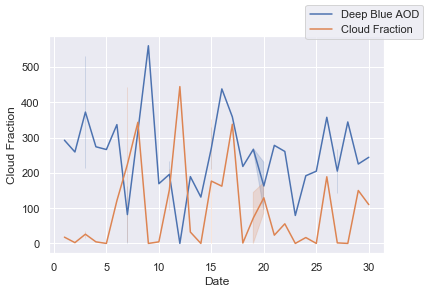

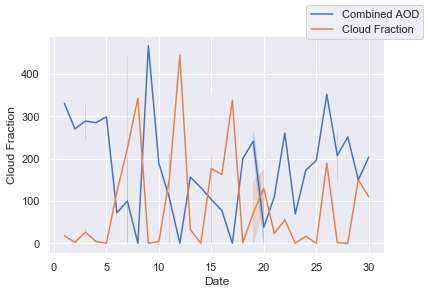

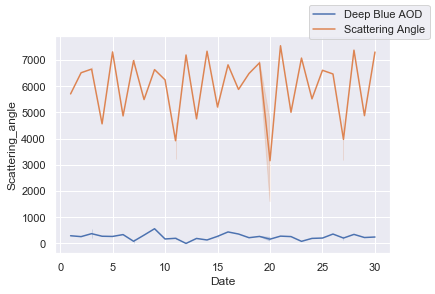

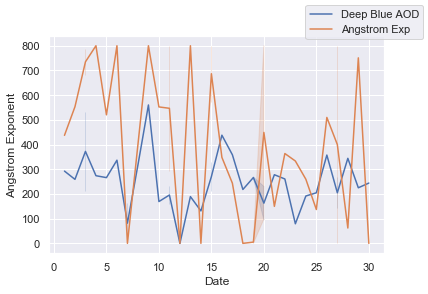

Printing data for Mar 2018


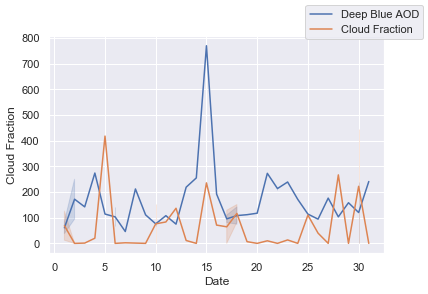

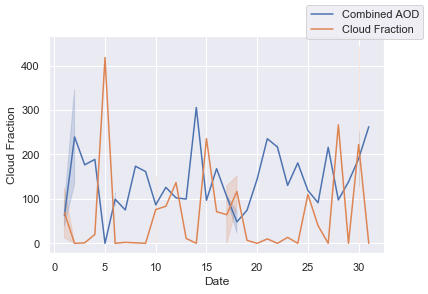

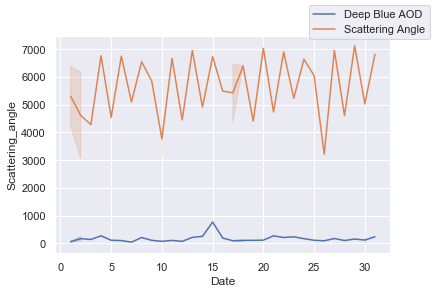

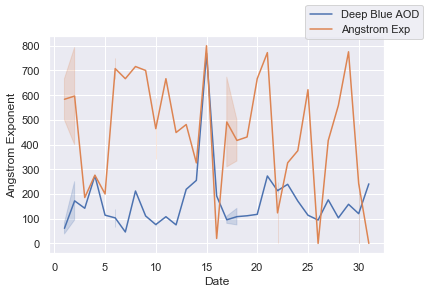

Printing data for Feb 2018


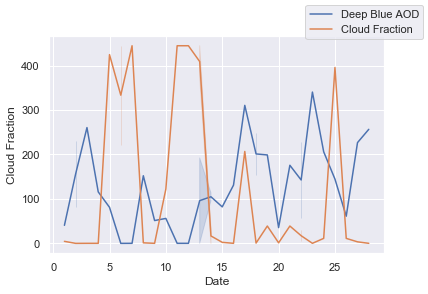

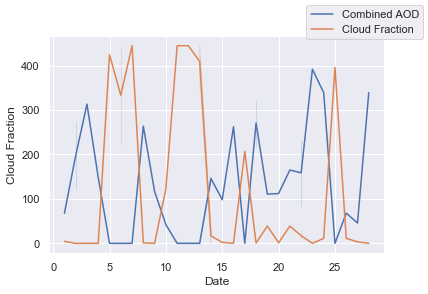

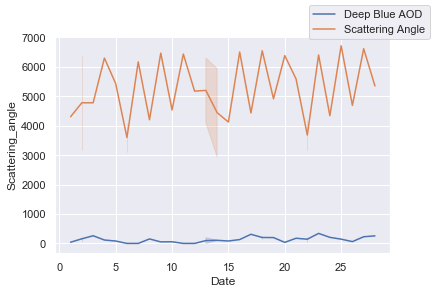

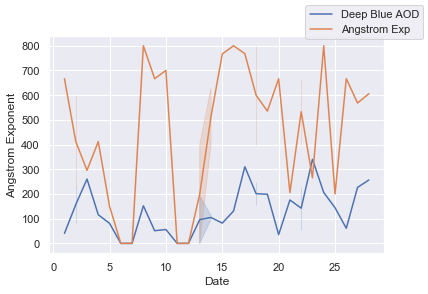

Printing data for Dec 2018


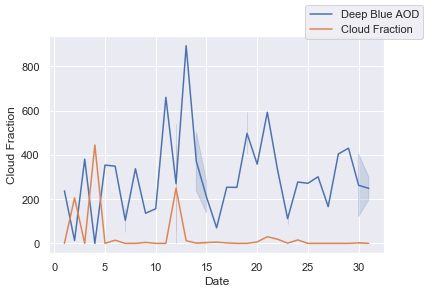

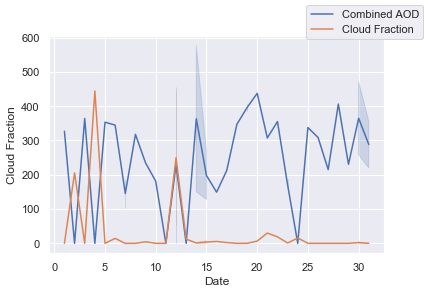

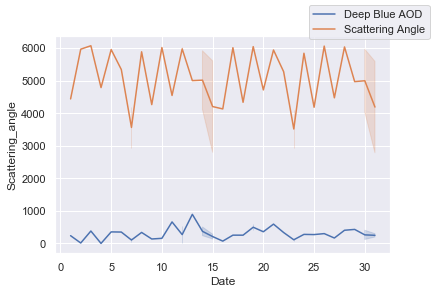

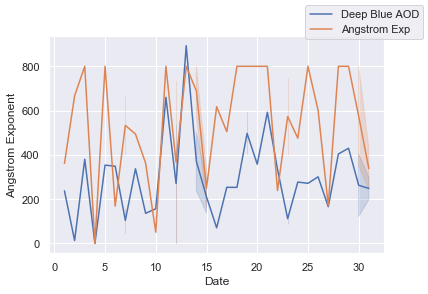

Printing data for May 2018


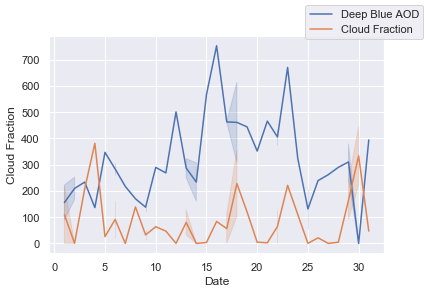

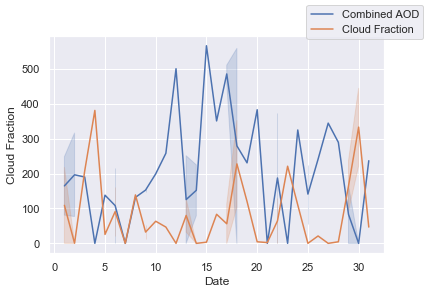

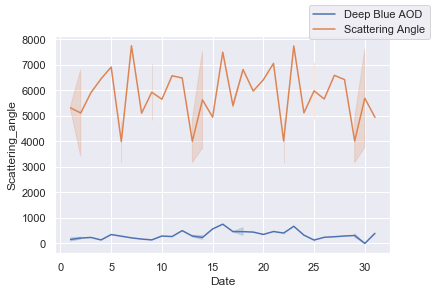

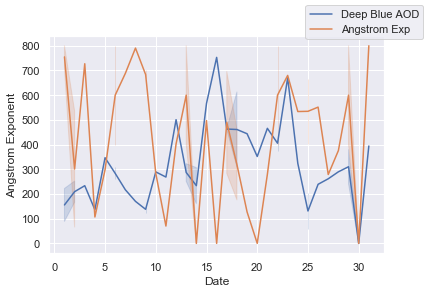

Printing data for Aug 2018


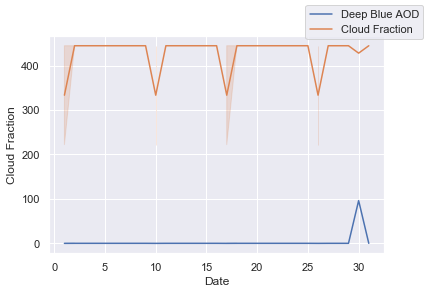

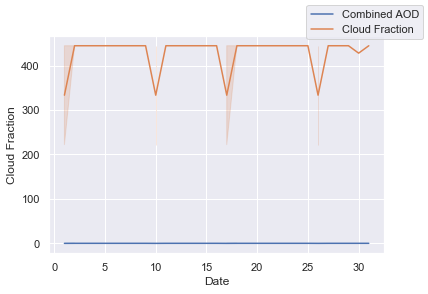

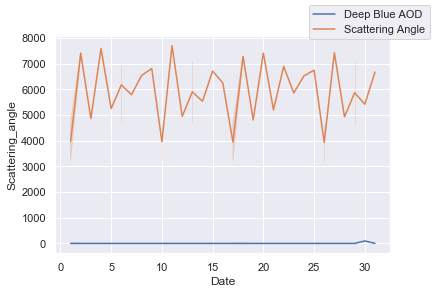

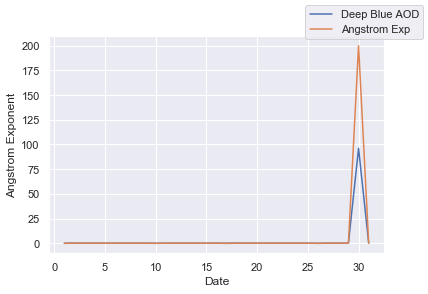

Printing data for Oct 2018


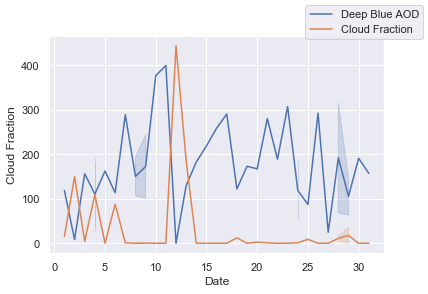

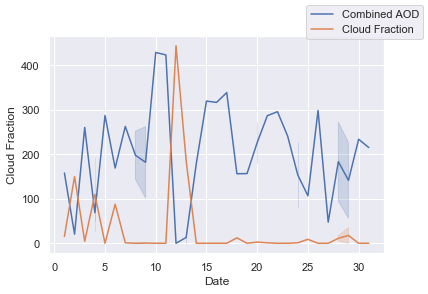

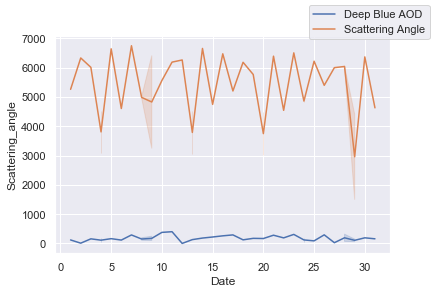

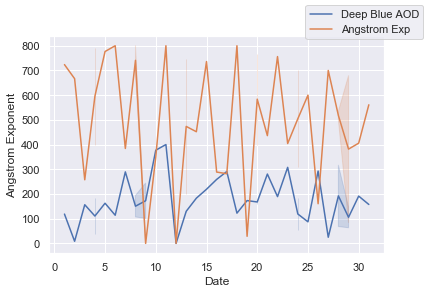

Printing data for Sep 2018


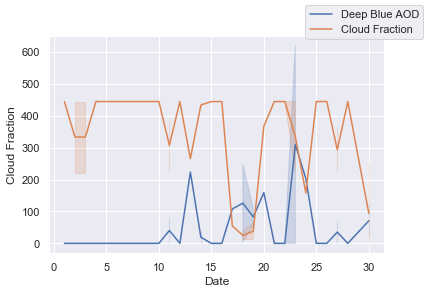

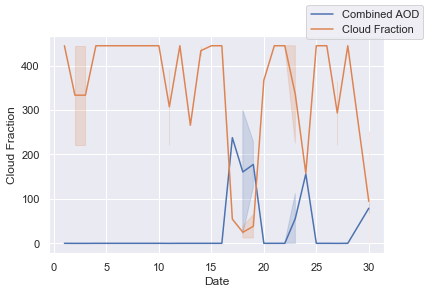

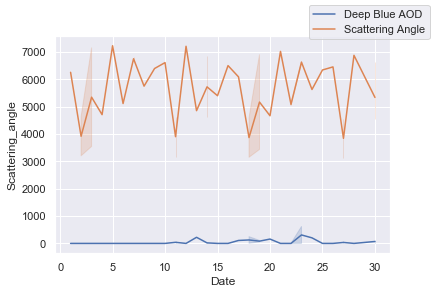

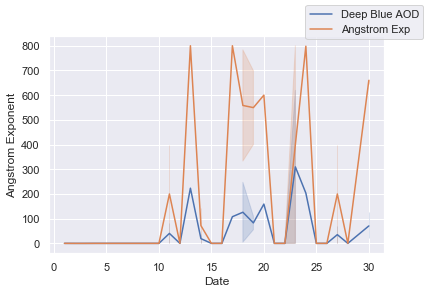

Printing data for Jun 2018


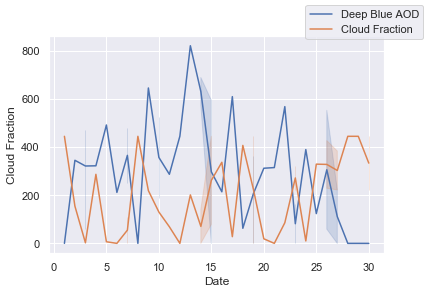

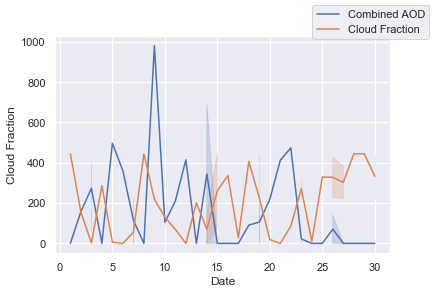

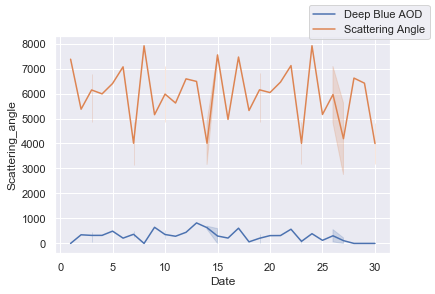

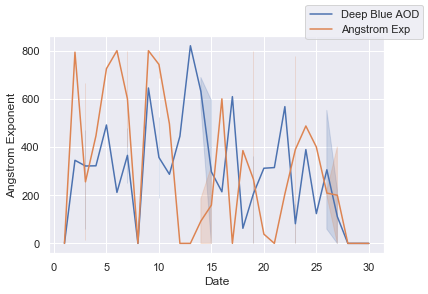

Printing data for Jul 2018


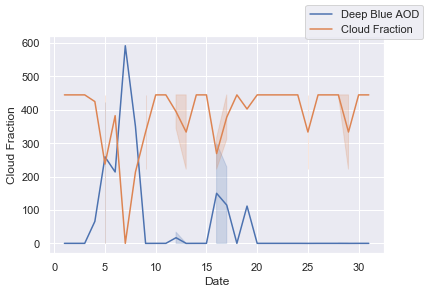

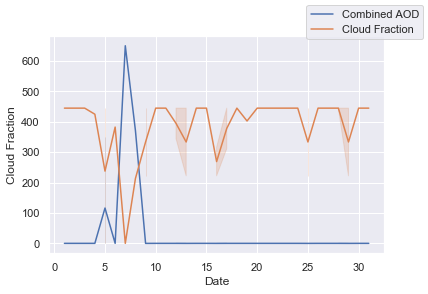

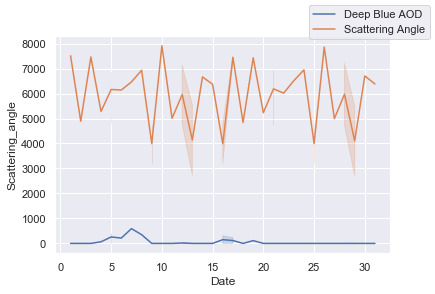

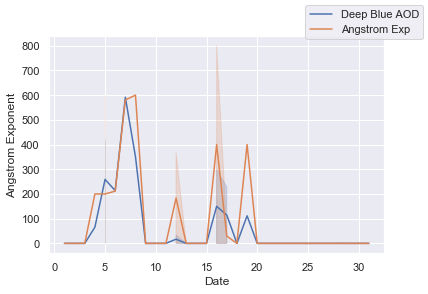

Printing data for Nov 2018


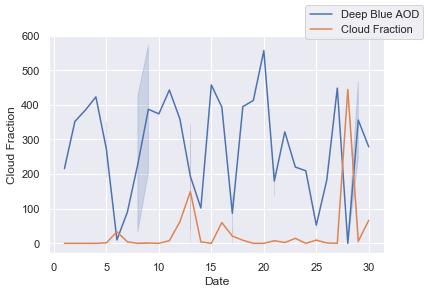

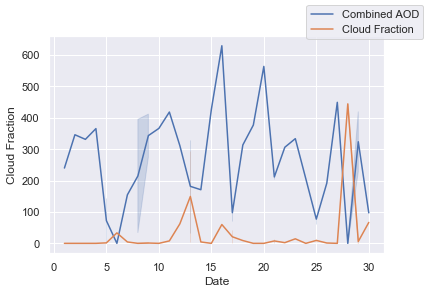

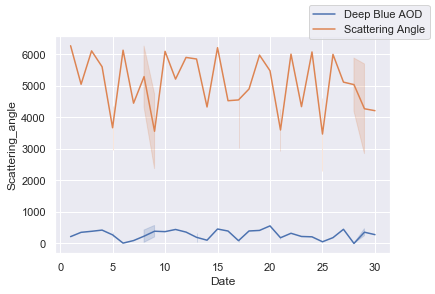

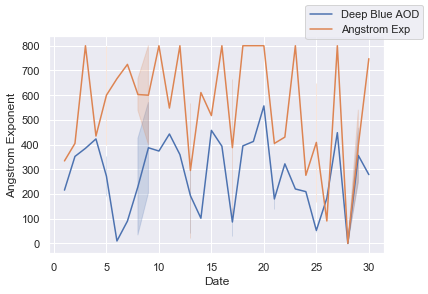

Printing data for Jan 2018


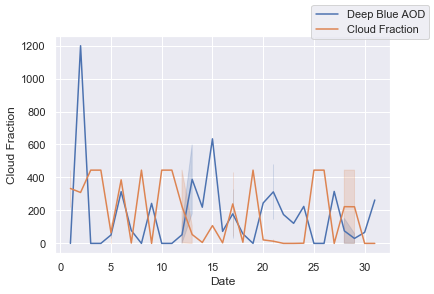

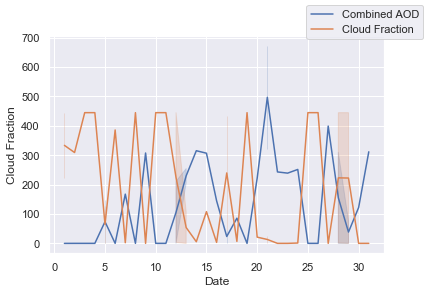

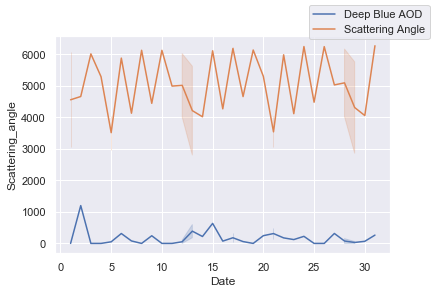

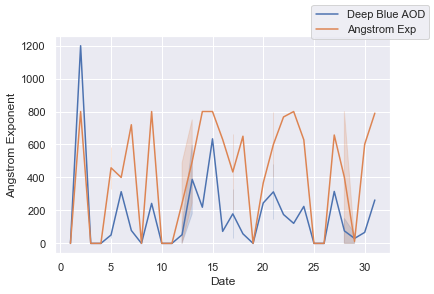

In [12]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov':11, 'Dec':12}
mean_month_list = []
mean_AOD_list = []
csv_directory = '/Users/nimishmishra/Downloads/Kanpur MODIS Data/CSV Files/'
for filename in glob.glob(csv_directory + '*.csv'):
    month = filename[63:66]
    print("Printing data for " + month + " " + str(2018))
    data = pd.read_csv(filename)
    date = data.Date
    deep_blue_AOD = data['Deep Blue AOD']
    cloud_fraction = data['Cloud Fraction']
    scattering_angle = data['Scattering_angle']
    angstrom = data['Angstrom Exponent']
    combined_AOD = data['Combined AOD']
    plot(date, deep_blue_AOD, cloud_fraction, "Deep Blue AOD", "Cloud Fraction", csv_directory, month)
    plot(date, combined_AOD, cloud_fraction, "Combined AOD", "Cloud Fraction", csv_directory, month)
    plot(date, deep_blue_AOD, scattering_angle, "Deep Blue AOD", "Scattering Angle", csv_directory, month)
    plot(date, deep_blue_AOD, angstrom, "Deep Blue AOD", "Angstrom Exp", csv_directory, month)
    mean_month_list.append(month_dict[month])
    mean_AOD_list.append(create_averaged_data(deep_blue_AOD))

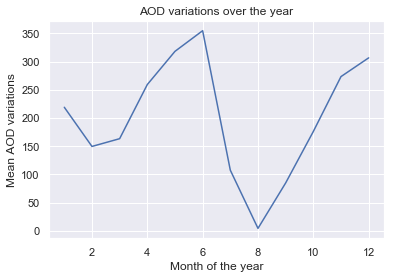

In [23]:
figure = plt.figure()
ax = sns.lineplot(x = mean_month_list, y = mean_AOD_list)
plt.xlabel('Month of the year')
plt.ylabel('Mean AOD variations')
plt.title("AOD variations over the year")
plt.show()